In [1]:
# Needed Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns
import networkx as nx
from torch.utils.data import DataLoader
import torchvision.transforms as transf
from data_feed import DataFeed, DataFeed_image_pos
from build_net import resnet50, NN_beam_pred, MultinomialLogisticRegression


In [2]:
# Fixing the seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# or full reproducibility
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable to move your model and data to the correct device
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Directory containing the saved CSV files
output_dir = "./feature_nonIID/"

# Load one of the CSV files for EDA (e.g., user_0_outputs.csv)
df = pd.read_csv(output_dir + "user_0_pos_height_beam.csv")

# Quick overview of the data
print("Data Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Data Overview:
   index_x  unit2_lat  unit2_lon  unit2_height  unit2_distance  \
0      871   0.387864   0.413107      0.199818        0.148270   
1     1431   0.444764   0.439928      0.748175        0.097968   
2     1645   0.526002   0.481266      0.656022        0.174207   
3     5350   0.359438   0.415872      0.177920        0.139243   
4     3228   0.564458   0.511683      0.781022        0.226075   

                                           unit1_rgb  unit1_beam_x  \
0  ./../Carla/datasets/scenario23_dev//unit1/came...            15   
1  ./../Carla/datasets/scenario23_dev//unit1/came...            17   
2  ./../Carla/datasets/scenario23_dev//unit1/came...            17   
3  ./../Carla/datasets/scenario23_dev//unit1/came...            17   
4  ./../Carla/datasets/scenario23_dev//unit1/came...            17   

   lat_region  lon_region  region  
0           1           1       3  
1           1           1       3  
2           1           1       3  
3           1          

In [5]:
########################################################################
########################### Data pre-processing ########################
########################################################################
no_users = 20
batch_size = 64
img_resize = transf.Resize((224, 224))
img_norm = transf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
proc_pipe = transf.Compose(
    [transf.ToPILImage(),
     img_resize,
     transf.ToTensor(),
     img_norm]
)
dataset_dir = "feature_nonIID/"
train_loaders = []
test_loaders = []
val_loaders = []

for user_id in range(no_users):
    train_dir = dataset_dir + f'user_{user_id}_pos_height_beam_train.csv'
    val_dir = dataset_dir + f'user_{user_id}_pos_height_beam_val.csv'
    test_dir = dataset_dir + f'user_{user_id}_pos_height_beam_test.csv'
    
    train_dataset = DataFeed_image_pos(train_dir, transform=proc_pipe)
    val_dataset = DataFeed_image_pos(root_dir=val_dir, transform=proc_pipe)
    test_dataset = DataFeed_image_pos(root_dir=test_dir, transform=proc_pipe)
    
    
    train_loaders.append(DataLoader(train_dataset,
                              batch_size=batch_size,
                              #num_workers=8,
                              shuffle=True))
    val_loaders.append(DataLoader(val_dataset,
                            batch_size=batch_size,
                            #num_workers=8,
                            shuffle=False))
    test_loaders.append(DataLoader(test_dataset,
                            batch_size=batch_size,
                            #num_workers=8,
                            shuffle=False))
print("All loadred are loaded")

All loadred are loaded


In [6]:
# Model Preperation#
all_models = []
available_modalities = ["pos_height", "images"]
modality_size = {"pos_height": 128, "images": 128}


In [7]:
# Configuration
import random
no_users = 20  # Example: Number of users
available_modalities = ["pos_height", "images"]
modality_size = {"pos_height": 128, "images": 128}
group_definitions = {
    1: ["pos_height"],        # Group 1: Only pos_height
    2: ["images"],            # Group 2: Only images
    3: ["pos_height", "images"]  # Group 3: Both modalities
}

# Assign each user to a group randomly
weights = [0.2, 0.3, 0.5]  # Probabilities for groups 1, 2, and 3

# Generate user_groups with weighted random choices
user_groups = random.choices([1, 2, 3], weights=weights, k=no_users)

# Assign modalities to users based on their group
user_modalities = [group_definitions[group] for group in user_groups]

# Compute output sizes for each user based on their modalities
output_sizes = [sum(modality_size[modality] for modality in user_modality) for user_modality in user_modalities]

# Store models (placeholders for actual models)
all_models = []

# Example output (for verification)
print(f"User Groups: {user_groups[:10]}")  # Show first 10 users' groups
print(f"User Modalities: {user_modalities[:10]}")  # Show first 10 users' modalities
print(f"Output Sizes: {output_sizes[:10]}")  # Show first 10 users' output sizes

User Groups: [3, 1, 2, 2, 3, 3, 3, 1, 2, 1]
User Modalities: [['pos_height', 'images'], ['pos_height'], ['images'], ['images'], ['pos_height', 'images'], ['pos_height', 'images'], ['pos_height', 'images'], ['pos_height'], ['images'], ['pos_height']]
Output Sizes: [256, 128, 128, 128, 256, 256, 256, 128, 128, 128]


In [8]:
def sinkhorn_knopp(matrix, tol=1e-9, max_iter=1000):
    """
    Converts a given matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    Parameters:
        matrix (np.ndarray): The input matrix to be transformed.
        tol (float): The tolerance for convergence.
        max_iter (int): Maximum number of iterations for convergence.
    
    Returns:
        np.ndarray: A doubly stochastic matrix.
    """
    matrix = matrix.copy()
    for _ in range(max_iter):
        # Normalize rows
        row_sums = matrix.sum(axis=1, keepdims=True)
        matrix /= row_sums

        # Normalize columns
        col_sums = matrix.sum(axis=0, keepdims=True)
        matrix /= col_sums

        # Check for convergence
        if np.allclose(matrix.sum(axis=1), 1, atol=tol) and np.allclose(matrix.sum(axis=0), 1, atol=tol):
            break

    return matrix
    
def create_random_topology(num_users, similarity_matrix, edge_probability=0.3):
    """
    Creates a connected random topology using NetworkX.
    Returns the adjacency matrix.
    """
    while True:
        graph = nx.erdos_renyi_graph(num_users, edge_probability)
        adjacency_matrix = nx.to_numpy_array(graph)
        new_adj = np.multiply(adjacency_matrix, similarity_matrix)
        new_graph = nx.from_numpy_array(new_adj)
        if nx.is_connected(new_graph):
            break

    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(new_graph)
    return adjacency_matrix

def prepare_mixing_matrices(adjacency_matrix, similarity_matrices):
    """
    Computes a mixing matrix for each modality by multiplying the adjacency matrix 
    with the similarity matrix for that modality.
    Returns a dictionary of mixing matrices.
    """
    adjacency_matrices = {}
    mixing_matrices = {}
    for modality, similarity_matrix in similarity_matrices.items():
        # Element-wise multiplication of adjacency and similarity matrices
        combined_matrix = adjacency_matrix * similarity_matrix
        adjacency_matrices[modality] = combined_matrix
        
        # Normalize to create a doubly matrix
        mixing_matrix = sinkhorn_knopp(combined_matrix)
        
        
        mixing_matrices[modality] = mixing_matrix
    
    return mixing_matrices, adjacency_matrices




In [9]:
# Create random connected topology
#adjacency_matrix = create_random_topology(no_users, edge_probability=0.3)
# Initialize adjacency matrix
similarity_matrix = np.zeros((no_users, no_users), dtype=int)

# Construct the adjacency matrix
for i in range(no_users):
    for j in range(no_users):
        if i != j:  # No self-loops
            # Check if users i and j share any modalities
            if set(user_modalities[i]) & set(user_modalities[j]):
                similarity_matrix[i, j] = 1

# Display the adjacency matrix
print("Adjacency Matrix:")
print(similarity_matrix)

# Prepare mixing matrices for each modality
#mixing_matrices, adjacency_matrices = prepare_mixing_matrices(adjacency_matrix, similarity_matrices)
adjacency_matrix = create_random_topology(20, similarity_matrix, edge_probability=0.3)
print(adjacency_matrix)

Adjacency Matrix:
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0]
 [1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1]
 [1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0]
 [1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1]
 [1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1]
 [1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0]]
[[0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.

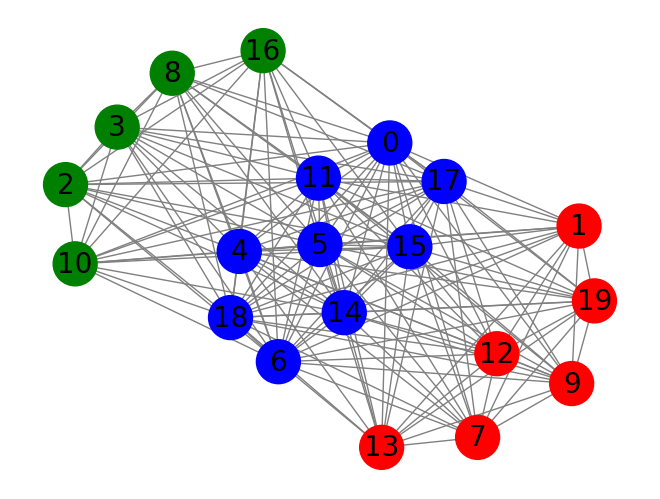

In [10]:
# Draw the graph
# Define colors for the groups
group_colors = {1: 'red', 2: 'green', 3: 'blue'}
node_colors = [group_colors[group] for group in user_groups]
G = nx.from_numpy_array(similarity_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color='gray', node_size=1000, node_color=node_colors, font_size=20, font_color='black')

# Show the plot
plt.show()

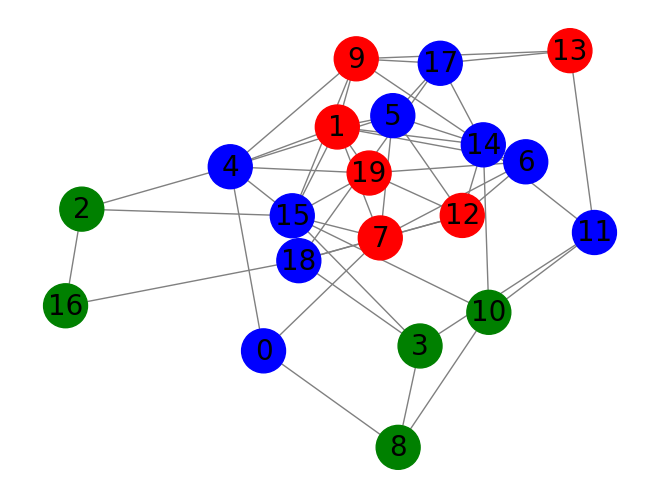

[3, 1, 2, 2, 3, 3, 3, 1, 2, 1, 2, 3, 1, 1, 3, 3, 2, 3, 3, 1]


In [11]:
# Draw the graph





G = nx.from_numpy_array(adjacency_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color='gray', node_size=1000, node_color=node_colors, font_size=20, font_color='black')

# Show the plot
plt.show()
print(user_groups)

In [12]:
# Similarity matrices
adj_per_modality = {}
for modality in available_modalities:
    adj = np.zeros((no_users, no_users))
    for node in range(no_users):
        for neighbor in G.neighbors(node):
            if modality in user_modalities[neighbor] and modality in user_modalities[node]:
                adj[node, neighbor] = 1.    
    adj_per_modality[modality] = adj


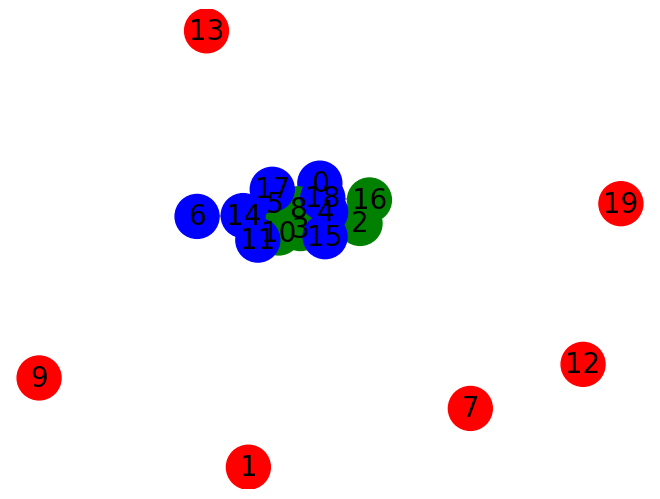

In [13]:
G_modality = nx.from_numpy_array(adj_per_modality["images"])
pos = nx.spring_layout(G_modality)
nx.draw(G_modality, pos, with_labels=True, edge_color='gray', node_size=1000, node_color=node_colors, font_size=20, font_color='black')

# Show the plot
plt.show()

In [14]:
def construct_mixing_matrix(Adj, method="metropolis"):
    n = Adj.shape[0]
    W = np.zeros((n, n))  # Initialize weight matrix

    for i in range(n):
        degree_i = np.sum(Adj[i, :])

        for j in range(n):
            if Adj[i, j] == 1.0:
                degree_j = np.sum(Adj[j, :])
    
                if method == "metropolis":
                    W[i, j] = 1 / (max(degree_i, degree_j) + 1)
                elif method == "uniform":
                    W[i, j] = 1 / degree_i

        # Diagonal weight
        W[i, i] = 1 - np.sum(W[i, :])

    return W

mixing_matrices = {}
for modality in available_modalities:
    mixing_matrices[modality] = construct_mixing_matrix(adj_per_modality[modality], method="metropolis")
    print(np.sum(mixing_matrices[modality], 0))
    print(np.sum(mixing_matrices[modality], 1))
    lamb = np.linalg.eigvals(mixing_matrices[modality])
    lamb.sort()
    print(lamb)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.18657211 -0.17108988 -0.07897989 -0.00891514  0.0799681   0.10111843
  0.20510575  0.21516226  0.32793234  0.4228934   0.52751972  0.65907464
  0.74368903  0.83769652  1.          1.          1.          1.
  1.          1.        ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.29675047 -0.14945858 -0.07938702 -0.03321245  0.09584647  0.18246951
  0.29570117  0.37530677  0.58405854  0.67423905  0.71489261  0.7925339
  0.87709383  1.          1.          1.          1.          1.
  1.          1.        ]


In [15]:
G_modality = nx.from_numpy_array(adj_per_modality["pos_height"])
pos = nx.spring_layout(G_modality)
largest_cc = max(nx.connected_components(G_modality), key=len)

# Convert to sorted list of indices
connected_nodes = sorted(largest_cc)

# Extract the submatrix corresponding to the connected subgraph
W_reduced = mixing_matrices["pos_height"][np.ix_(connected_nodes, connected_nodes)]
lamb = np.linalg.eigvals(W_reduced)
lamb.sort()
print(lamb)

[-0.18657211 -0.17108988 -0.07897989 -0.00891514  0.0799681   0.10111843
  0.20510575  0.21516226  0.32793234  0.4228934   0.52751972  0.65907464
  0.74368903  0.83769652  1.        ]


In [16]:
# Image Feature Extractor
class ImageFeatureExtractor(nn.Module):
    def __init__(self, output_dim=128):
        super(ImageFeatureExtractor, self).__init__()
        base_model = resnet50(pretrained=True, num_classes=64)
        #base_model.fc = nn.Identity()  # Remove classification layer
        self.feature_extractor = base_model
        #self.fc = nn.Linear(128, output_dim)  # Project to desired output dimension
        self.bn = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        #x = self.fc(x)
        x = self.bn(x)
        return x

# Position Feature Extractor
class PosFeatureExtractor(nn.Module):
    def __init__(self, input_dim=4, output_dim=128):
        super(PosFeatureExtractor, self).__init__()
        self.feature_extractor = NN_beam_pred(num_features=input_dim, num_output=output_dim)
        self.bn = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.bn(x)
        return x

# Classification Head
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes=64):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Main Model with Named Sub-Networks
class Classifier(nn.Module):
    def __init__(self, use_image=True, use_pos=True, feature_dim=128, num_classes=64):
        super(Classifier, self).__init__()
        
        # Store sub-networks in a dictionary
        self.sub_networks = nn.ModuleDict()

        if use_image:
            self.sub_networks["images"] = ImageFeatureExtractor(output_dim=feature_dim)
        if use_pos:
            self.sub_networks["pos_height"] = PosFeatureExtractor(output_dim=feature_dim)

        # Determine input size for classification head
        input_dim = (feature_dim if use_image else 0) + (feature_dim if use_pos else 0)
        self.classifier = ClassificationHead(input_dim, num_classes)

    def forward(self, images=None, pos_height=None):
        features = []

        if "images" in self.sub_networks and images is not None:
            features.append(self.sub_networks["images"](images))

        if "pos_height" in self.sub_networks and pos_height is not None:
            features.append(self.sub_networks["pos_height"](pos_height))

        if not features:
            raise ValueError("At least one modality (image or pos) must be used")

        x = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.classifier(x)


In [17]:
model = Classifier(use_image=True, use_pos=True)

# Extract the image feature extractor using its name
image_extractor = model.sub_networks["pos_height"]

classifier_head = model.classifier


Output layer dim = 64
<class 'build_net.Bottleneck'>


/usr/lib64/python3.9/tarfile.py:2239: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  warnings.warn(


In [18]:
optimizer1 = optim.Adam(model.sub_networks["pos_height"].parameters(), lr=1e-3)
optimizer2 = optim.Adam(model.sub_networks["images"].parameters(), lr=1e-3)
optimizer3 = optim.Adam(model.classifier.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()



In [19]:
lr = 1e-3
optimizers = []
all_models = []
classifier_optimizers = []
for user_id in range(no_users):
    if "images" in user_modalities[user_id] and "pos_height" in user_modalities[user_id]:
        user_model = Classifier(use_image=True, use_pos=True).to(device)
    elif "pos_height" in user_modalities[user_id]:
        user_model = Classifier(use_image=False, use_pos=True).to(device)
    elif "images" in user_modalities[user_id]:
        user_model = Classifier(use_image=True, use_pos=False).to(device)
    local_optimizer = optim.Adam(user_model.parameters(), lr=lr)
    class_optim = optim.Adam(user_model.classifier.parameters(), lr=lr)

    all_models.append(user_model)
    optimizers.append(local_optimizer)
    classifier_optimizers.append(class_optim)
base_models = Classifier(use_image=True, use_pos=True).to(device)

Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>


In [20]:
factor = 0.2
neighbors = [np.nonzero(adjacency_matrix[i])[0].tolist() for i in range(no_users)]

# Initialize P_ij matrices
# Initialize P_ij matrices
P = {}
for i, j in zip(*adjacency_matrix.nonzero()):
    num_params_i = sum(p.numel() for p in all_models[i].classifier.parameters())
    num_params_j = sum(p.numel() for p in all_models[j].classifier.parameters())
    P[(i, j)] = torch.randn(int(factor*(num_params_i + num_params_j) // 2), num_params_i)
    P[(j, i)] = torch.randn(int(factor*(num_params_i + num_params_j) // 2), num_params_j)

In [21]:


# Decentralized aggregation function
def per_modelaity_decentralized_aggregation(user_models, mixing_matrices, available_modalities, user_modalities, base_models):
    num_users = len(user_models)
    with torch.no_grad():
        for modality in available_modalities:
            # Get the mixing matrix for the current modality
            mixing_matrix = mixing_matrices[modality]
            
            # Convert user model parameters to vectors for aggregation
            aggregated_models = []
            aggregated_updates = []
            for user_id, user_model in enumerate(user_models):
                if modality in user_modalities[user_id]:
                    aggregated_models.append(torch.nn.utils.parameters_to_vector(user_model.sub_networks[modality].parameters()))
                    aggregated_updates.append(torch.zeros_like(aggregated_models[-1]))
                else:
                    aggregated_models.append(0)
                    aggregated_updates.append(0)
            
            
            # Perform model aggregation based on the mixing matrix for this modality
            for i in range(num_users):
                for j in range(num_users):
                    if mixing_matrix[i, j] > 0:
                        aggregated_updates[i] += mixing_matrix[i, j] * aggregated_models[j]
            
            # Update user models with aggregated parameters for the current modality
            for user_id in range(num_users):
                if modality in user_modalities[user_id]:
                    torch.nn.utils.vector_to_parameters(aggregated_updates[user_id], user_models[user_id].sub_networks[modality].parameters())

#per_modelaity_decentralized_aggregation(all_models, mixing_matrices, available_modalities, user_modalities, base_models)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_local_model(local_modalities, model, train_loader, criterion, optimizer, epochs, device):
    """
    Trains a local multi-modal model.

    Args:
        local_modalities (list): Modalities to use (e.g., ['image', 'pos']).
        model (Classifier): Multi-modal classification model.
        train_loader (DataLoader): Training data loader.
        criterion (nn.CrossEntropyLoss): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        epochs (int): Number of training epochs.
        device (torch.device): Device (CPU/GPU).

    Returns:
        tuple: Minimum training loss, maximum training accuracy.
    """
    # Unfreeze the layers
    # freezing first layers 
    for mod in local_modalities:
        for param in model.sub_networks[mod].parameters():
            param.requires_grad = True  # Freezes the feature extractor
    model.to(device)
    model.train()

    training_losses = []
    training_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            inputs, labels = batch

            # Prepare input data for selected modalities
            modality_inputs = {mod: inputs[mod].to(device) for mod in local_modalities}
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(**modality_inputs)

            # Compute loss
            loss = criterion(model, outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Compute loss and accuracy
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0

        training_losses.append(avg_loss)
        training_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return min(training_losses), max(training_accuracies)


In [23]:
def validate_user_models(user_id, model, val_loader, criterion, local_modalities, device):
    """
    Validates a trained multi-modal model.

    Args:
        user_id (int): User identifier.
        model (Classifier): Multi-modal classification model.
        val_loader (DataLoader): Validation data loader.
        criterion (nn.CrossEntropyLoss): Loss function.
        local_modalities (list): Modalities to use (e.g., ['image', 'pos']).
        device (torch.device): Device (CPU/GPU).

    Returns:
        dict: Validation loss and accuracy.
    """
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch

            # Prepare input data for selected modalities
            modality_inputs = {mod: inputs[mod].to(device) for mod in local_modalities}
            labels = labels.to(device)

            # Forward pass
            outputs = model(**modality_inputs)
            loss = criterion(model, outputs, labels)

            # Accumulate metrics
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Compute loss and accuracy
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    print(f"User {user_id + 1} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return {"loss": avg_loss, "accuracy": accuracy}


In [24]:
import torch

def fmtl_aggregation(classifiers, optimizers, train_loaders, user_modalities, user_groups, no_users, adjacency_matrix, P, alpha, lambda_reg, eta, criterion, device):
    """
    Perform FMTL Aggregation while only updating model.classifier.
    
    Args:
        classifiers (dict): Dictionary of user classifier models.
        optimizers (dict): Dictionary of user optimizers.
        train_loaders (dict): Dictionary of user train loaders.
        user_modalities (dict): Dictionary mapping each user to their available modalities.
        user_groups (dict): Mapping of users to groups.
        no_users (int): Number of users.
        adjacency_matrix (torch.Tensor): Adjacency matrix for FMTL.
        P (dict): Projection matrices for FMTL.
        alpha (float): Learning rate scaling factor.
        lambda_reg (float): Regularization parameter.
        eta (float): Step size for projection updates.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Computation device.
    """
    for i, j in zip(*adjacency_matrix.nonzero()):
        P[(i, j)] = P[(i, j)].to(device)
        P[(j, i)] = P[(j, i)].to(device)

    for user_id in range(no_users):
        print(f"FMTL: {user_id}")
        client_model = classifiers[user_id]  # Get user's model
        optimizer = optimizers[user_id]      # Get optimizer
        train_loader = train_loaders[user_id]  # Get train loader
        modalities = user_modalities[user_id]  # Get list of modalities for user
        group = user_groups[user_id]           # Get user's group

        # freezing first layers 
        for mod in modalities:
            for param in client_model.sub_networks[mod].parameters():
                param.requires_grad = False  # Freezes the feature extractor

        epoch_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        # Set model to training mode
        client_model.train()

        for batch in train_loader:
            inputs, labels = batch

            # Prepare input data for selected modalities
            modality_inputs = {mod: inputs[mod].to(device) for mod in modalities}
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass using selected modalities
            predictions = client_model(**modality_inputs)
            loss = criterion(client_model, predictions, labels)

            # Backpropagation (only for classifier)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(predictions, dim=1)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples

        # ==============================
        #        FMTL Parameter Update
        # ==============================
        with torch.no_grad():
            # Extract classifier parameters only
            theta_i = torch.cat([param.view(-1) for param in client_model.classifier.parameters()])
            sum_P_terms = torch.zeros_like(theta_i, device=device)
            projection_norm = 0

            for j in range(no_users):
                if adjacency_matrix[user_id, j] == 1:
                    P_ij = P[(user_id, j)]
                    P_ji = P[(j, user_id)]
                    theta_j = torch.cat([param.view(-1) for param in classifiers[j].classifier.parameters()])
                    
                    sum_P_terms += P_ij.T @ (P_ij @ theta_i - P_ji @ theta_j)
                    projection_norm += torch.linalg.norm(P_ij @ theta_i - P_ji @ theta_j, ord=1, dim=0)

            if user_id == 0:
                print(f"Norm of difference: {projection_norm}")

            # Apply FMTL update rule
            theta_i -= alpha * lambda_reg * sum_P_terms

            # Update classifier parameters only
            idx = 0
            for param in client_model.classifier.parameters():
                numel = param.numel()
                param.data.copy_(theta_i[idx:idx+numel].reshape(param.size()))
                idx += numel

            # Projection matrix update
            for j in range(no_users):
                if adjacency_matrix[user_id, j] == 1:
                    P_ij = P[(user_id, j)]
                    P_ji = P[(j, user_id)]
                    theta_j = torch.cat([param.view(-1) for param in classifiers[j].classifier.parameters()])
                    
                    P[(user_id, j)] -= eta * lambda_reg * torch.outer(P_ij @ theta_i - P_ji @ theta_j, theta_i)


    for i, j in zip(*adjacency_matrix.nonzero()):
        P[(i, j)] = P[(i, j)].to("cpu")
        P[(j, i)] = P[(j, i)].to("cpu")



In [25]:
def cross_entropy_loss_with_l2(model, logits, targets, l2_strength=1e-3):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits, targets)
    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
    
    return loss + l2_strength * l2_reg 

In [26]:
import numpy as np
import torch
import torch.nn as nn

# Hyperparameters
lambda_reg = 0.01
eta = 0.001
alpha = 1e-3
# Dictionaries to store metrics
group_train_loss_histories = {1: [], 2: [], 3: []}
group_train_accuracy_histories = {1: [], 2: [], 3: []}
group_val_loss_histories = {1: [], 2: [], 3: []}
group_val_accuracy_histories = {1: [], 2: [], 3: []}
criterion = cross_entropy_loss_with_l2#nn.CrossEntropyLoss()

global_rounds = 100
local_epochs = 1

# Decentralized Federated Learning Loop
for round_num in range(global_rounds):
    print(f"Global Round {round_num + 1}")

    # Decentralized aggregation step

    # Temporary storage for this round
    epoch_group_train_losses = {1: [], 2: [], 3: []}
    epoch_group_train_accuracies = {1: [], 2: [], 3: []}
    epoch_group_val_losses = {1: [], 2: [], 3: []}
    epoch_group_val_accuracies = {1: [], 2: [], 3: []}

    

    print("FinishedFMTLAggregatin")
    # Training phase
    for user_id in range(no_users):
        print(f"Training model for User {user_id + 1}")
        user_models = all_models[user_id]
        group = user_groups[user_id]

        # Train local model for the user's available modalities

        train_loss, train_accuracy = train_local_model(
            user_modalities[user_id], 
            user_models, 
            train_loaders[user_id], 
            criterion, 
            optimizers[user_id], 
            local_epochs, 
            device
        )

  

        # Store in group-wise metrics
        epoch_group_train_losses[group].append(train_loss)
        epoch_group_train_accuracies[group].append(train_accuracy)

    per_modelaity_decentralized_aggregation(all_models, mixing_matrices, available_modalities, user_modalities, base_models)

    fmtl_aggregation(all_models, classifier_optimizers, train_loaders, user_modalities, user_groups, no_users, adjacency_matrix, P, alpha, lambda_reg, eta, criterion, device)


    # Validation phase
    for user_id in range(no_users):
        user_models = all_models[user_id]
        val_dict = validate_user_models(
            user_id, 
            user_models, 
            val_loaders[user_id], 
            criterion, 
            user_modalities[user_id], 
            device
        )
        group = user_groups[user_id]
        epoch_group_val_losses[group].append(val_dict["loss"])
        epoch_group_val_accuracies[group].append(val_dict["accuracy"])

    # Store final metrics for each group
    for group in [1, 2, 3]:
        group_train_loss_histories[group].append(epoch_group_train_losses[group])
        group_train_accuracy_histories[group].append(epoch_group_train_accuracies[group])
        group_val_loss_histories[group].append(epoch_group_val_losses[group])
        group_val_accuracy_histories[group].append(epoch_group_val_accuracies[group])

    # Print final results for this round
    print(f"---- Global Round {round_num + 1} Metrics ----")
    for group in [1, 2, 3]:
        print(f"  Group {group} - Train Loss: {np.mean(group_train_loss_histories[group][-1]):.4f}, Train Accuracy: {np.mean(group_train_accuracy_histories[group][-1]):.4f}")
        print(f"  Group {group} - Val Loss: {np.mean(group_val_loss_histories[group][-1]):.4f}, Val Accuracy: {np.mean(group_val_accuracy_histories[group][-1]):.4f}")


Global Round 1
FinishedFMTLAggregatin
Training model for User 1
Epoch [1/1] - Loss: 12.3347, Accuracy: 0.3661
Training model for User 2
Epoch [1/1] - Loss: 4.1145, Accuracy: 0.3006
Training model for User 3
Epoch [1/1] - Loss: 12.1700, Accuracy: 0.2827
Training model for User 4
Epoch [1/1] - Loss: 12.4905, Accuracy: 0.1935
Training model for User 5
Epoch [1/1] - Loss: 12.5123, Accuracy: 0.3780
Training model for User 6
Epoch [1/1] - Loss: 12.2979, Accuracy: 0.3750
Training model for User 7
Epoch [1/1] - Loss: 12.4077, Accuracy: 0.3542
Training model for User 8
Epoch [1/1] - Loss: 4.3489, Accuracy: 0.1071
Training model for User 9
Epoch [1/1] - Loss: 12.0440, Accuracy: 0.3571
Training model for User 10
Epoch [1/1] - Loss: 4.0879, Accuracy: 0.2946
Training model for User 11
Epoch [1/1] - Loss: 12.3634, Accuracy: 0.2530
Training model for User 12
Epoch [1/1] - Loss: 12.7103, Accuracy: 0.2679
Training model for User 13
Epoch [1/1] - Loss: 4.3032, Accuracy: 0.1012
Training model for User 14

KeyboardInterrupt: 

In [ ]:
'''
class MultiStreamNet(nn.Module):
    def __init__(self):
        super(MultiStreamNet, self).__init__()

        # Define the streams
        self.stream_1 = resnet50(pretrained=True, progress=True, num_classes=64)  # First stream using resnet50
        self.stream_2 = NN_beam_pred(num_features=4, num_output=64)  # Second stream using NN_beam_pred
        
        # Add Batch Normalization layers
        self.bn_stream_1 = nn.BatchNorm1d(128)  # Adjust according to the output size of resnet50
        self.bn_stream_2 = nn.BatchNorm1d(128)   # Adjust according to the output size of NN_beam_pred

        # Combine the two streams and apply Multinomial Logistic Regression
        self.fc = MultinomialLogisticRegression(input_size=256, num_classes=64)  # Adjust input_size & num_classes

    def forward(self, x1, x2):
        # Process through stream 1 (resnet50)
        out1 = self.stream_1(x1)
        out2 = self.bn_stream_1(out1)
        print(out1.shape)
        print(out2.shape)
        
        # Process through stream 2 (NN_beam_pred)
        out2 = self.stream_2(x2)
        out2 = self.bn_stream_2(out2)

        # Concatenate the outputs from both streams
        out = torch.cat((out1, out2), dim=1)
        
        # Final classification layer
        out = self.fc(out)
        
        return out

# Instantiate the model
model = MultiStreamNet().to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training loop
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            x, y = data  # Assuming inputs1 and inputs2 are from different streams
            x["images"], x["pos_height"], y = x["images"].to(device), x["pos_height"].to(device), y.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x["images"], x["pos_height"])
            
            # Calculate loss
            loss = criterion(outputs, y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Assuming `train_loader` is a DataLoader object containing the training data
train(model, train_loaders[0], criterion, optimizer)

'''

In [27]:
group_val_accuracy_histories

{1: [[0.0,
   0.44642857142857145,
   0.0,
   0.05952380952380952,
   0.08333333333333333,
   0.0],
  [0.0,
   0.44642857142857145,
   0.07738095238095238,
   0.05952380952380952,
   0.11904761904761904,
   0.03571428571428571],
  [0.5297619047619048,
   0.44642857142857145,
   0.07738095238095238,
   0.05952380952380952,
   0.11904761904761904,
   0.03571428571428571],
  [0.49404761904761907,
   0.44642857142857145,
   0.17261904761904762,
   0.05952380952380952,
   0.20833333333333334,
   0.03571428571428571],
  [0.4583333333333333,
   0.4642857142857143,
   0.30357142857142855,
   0.16666666666666666,
   0.2857142857142857,
   0.20833333333333334],
  [0.4583333333333333,
   0.3392857142857143,
   0.32142857142857145,
   0.25595238095238093,
   0.25595238095238093,
   0.30952380952380953],
  [0.5535714285714286,
   0.35119047619047616,
   0.4166666666666667,
   0.4107142857142857,
   0.30357142857142855,
   0.3273809523809524],
  [0.5238095238095238,
   0.32142857142857145,
   0.5,
 

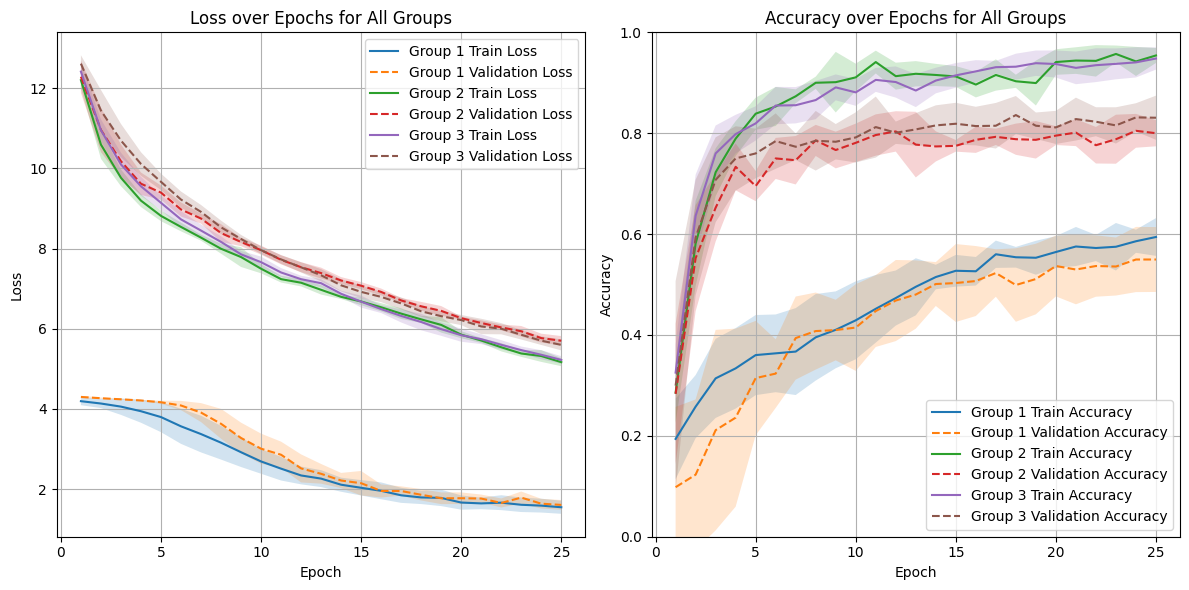

In [30]:
num_epochs = 25#global_rounds
# Convert metrics to numpy arrays for easy manipulation
group_train_loss_histories = {k: np.array(v) for k, v in group_train_loss_histories.items()}
group_train_accuracy_histories = {k: np.array(v) for k, v in group_train_accuracy_histories.items()}
group_val_loss_histories = {k: np.array(v) for k, v in group_val_loss_histories.items()}
group_val_accuracy_histories = {k: np.array(v) for k, v in group_val_accuracy_histories.items()}

# Handle potential one-dimensional arrays
group_train_loss_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_train_loss_histories.items()}
group_train_loss_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_loss_histories.items()}
group_val_loss_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_val_loss_histories.items()}
group_val_loss_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_loss_histories.items()}

group_train_acc_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_train_accuracy_histories.items()}
group_train_acc_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_accuracy_histories.items()}
group_val_acc_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_val_accuracy_histories.items()}
group_val_acc_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_accuracy_histories.items()}

# Combined Plot for All Modalities
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_loss_mean[group], label=f"Group {group} Train Loss")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_loss_mean[group] - group_train_loss_std[group], 
                     group_train_loss_mean[group] + group_train_loss_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_loss_mean[group], label=f"Group {group} Validation Loss", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_loss_mean[group] - group_val_loss_std[group], 
                     group_val_loss_mean[group] + group_val_loss_std[group], 
                     alpha=0.2)

plt.title("Loss over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_acc_mean[group], label=f"Group {group} Train Accuracy")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_acc_mean[group] - group_train_acc_std[group], 
                     group_train_acc_mean[group] + group_train_acc_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_acc_mean[group], label=f"Group {group} Validation Accuracy", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_acc_mean[group] - group_val_acc_std[group], 
                     group_val_acc_mean[group] + group_val_acc_std[group], 
                     alpha=0.2)

plt.title("Accuracy over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Ensure y-axis is between 0 and 1 for accuracy
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [31]:
import json

# Convert numpy arrays to lists for serialization
data_to_save = {
    "group_train_loss_mean": {k: v.tolist() for k, v in group_train_loss_mean.items()},
    "group_train_loss_std": {k: v.tolist() for k, v in group_train_loss_std.items()},
    "group_val_loss_mean": {k: v.tolist() for k, v in group_val_loss_mean.items()},
    "group_val_loss_std": {k: v.tolist() for k, v in group_val_loss_std.items()},
    "group_train_acc_mean": {k: v.tolist() for k, v in group_train_acc_mean.items()},
    "group_train_acc_std": {k: v.tolist() for k, v in group_train_acc_std.items()},
    "group_val_acc_mean": {k: v.tolist() for k, v in group_val_acc_mean.items()},
    "group_val_acc_std": {k: v.tolist() for k, v in group_val_acc_std.items()}
}

with open("FMTL_metrics_randn_P_adam_NIID.json", "w") as f:
    json.dump(data_to_save, f)
print("DSGD_metrics.json")

DSGD_metrics.json
